# Exercise 10: GANs

In [1]:
# Load packages we need
import sys
import os
import datetime

import numpy as np
import sklearn

import scipy as sp
import pandas as pd

import tensorflow as tf

# we'll use tensorflow and keras for neural networks
import tensorflow as tf
import tensorflow.keras as keras

# import layers we may use
from tensorflow.keras.layers import Input, Flatten, Reshape, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, LeakyReLU

# import callbacks we may use
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 20})

# Let's check our software versions
print('### Python version: ' + sys.version)
print('### Numpy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('### Tensorflow version: ' + tf.__version__)
print('------------')


# load our packages / code
sys.path.insert(1, '../common/')
import utils
import plots
import nets

### Python version: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
### Numpy version: 1.19.5
### Scikit-learn version: 0.24.1
### Tensorflow version: 2.4.1
------------


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9513389391185778578
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10257470592
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16689668475902944850
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10257470592
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17199160667946968608
physical_device_desc: "device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5"
]


In [4]:
print("Num XLA_GPUs Available: ", len(tf.config.list_physical_devices('XLA_GPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num XLA_GPUs Available:  0
Num GPUs Available:  2


In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [6]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.
seed = 42

# deterministic seed for reproducibility
np.random.seed(seed)
tf.random.set_seed(seed)

prop_vec = [24, 2, 2]

### Code to train the GAN

In [7]:
def gan_train_loop(gan, generator, discriminator, train_x, batch_size=200, latent_width=64, alpha=0.25, verbose=False):
       
    discr_loss_avg = 0.0
    gan_loss_avg = 0.0
        
    n = train_x.shape[0]
    num_full_batches = n / batch_size
    batch_idx = 0
    for i in range(0, n, batch_size):
        batch_start_idx = i
        batch_end_idx = np.minimum(n, batch_start_idx+batch_size)
        
        real_data_batch = train_x[batch_start_idx:batch_end_idx]
        
        # 1. train the discriminator for one step       
        # create batch of real & fake data
        eff_batch_size = real_data_batch.shape[0]
        noise_samples = tf.random.normal((eff_batch_size, latent_width), mean=0.0, stddev=1.0)
        fake_data_batch = generator.predict(noise_samples)
        
        # create the labels for these batches (1 -> real, 0 -> fake)
        discr_batch_real = tf.ones((eff_batch_size,), dtype=tf.float32)
        discr_batch_fake = tf.zeros((eff_batch_size,), dtype=tf.float32)
        discr_batch_y = tf.concat([discr_batch_real, discr_batch_fake], axis=0)
        
        # concatenate the two sets
        discr_batch_x = tf.concat([real_data_batch, fake_data_batch], axis=0)
        
        # train the discriminator for one step
        discriminator.trainable = True # make trainable
        discr_loss = discriminator.train_on_batch(discr_batch_x, discr_batch_y)
        
        # moving average for discr_loss
        discr_loss_avg = discr_loss if i==0 else alpha * discr_loss + (1.0 - alpha) * discr_loss_avg
        
        
        # 2. train the generator for one step       
        noise_samples = tf.random.normal([batch_size, latent_width], mean=0.0, stddev=1.0)
                
        # create the labels (pretend these are real images -> label = 1)
        pretend_labels = tf.ones((batch_size,), dtype=tf.float32)
        
        # do one training step
        discriminator.trainable = False # freeze the discriminator
        gan_loss = gan.train_on_batch(noise_samples, pretend_labels)
        
        # moving average for gan_loss
        gan_loss_avg = gan_loss if i==0 else alpha * gan_loss + (1.0 - alpha) * gan_loss_avg
        
        # verbose
        if verbose:
            if np.mod(batch_idx, num_full_batches // 10) == 0:                                      
                sys.stdout.write('.')
                sys.stdout.flush()
            
            if batch_end_idx == n:
                noise_samples = tf.random.normal([batch_size, latent_width], mean=0.0, stddev=1.0)
                gen_samples = generator.predict(noise_samples)
                plots.plot_images(gen_samples[0:10].reshape(-1, 28, 28), dim_x=28, dim_y=28, one_row=True, fig_size=(14,3))
        
        batch_idx += 1
        
    if verbose:   
        sys.stdout.write('\n')
        sys.stdout.flush()
        
    return discr_loss_avg, gan_loss_avg

### Load MNIST data.

In [8]:
# grab the data
train_x, train_y, test_x, test_y, val_x, val_y, all_x, all_y = utils.load_preprocess_mnist_data(onehot=False, flatten=False, prop_vec=prop_vec, seed=seed)

# sanity check shapes
train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape

((60000, 28, 28), (60000,), (5000, 28, 28), (5000,), (5000, 28, 28), (5000,))

In [9]:
# renormalize the data so all pixel values are in the [0,1] range 
train_x = train_x / 255.0
test_x = test_x / 255.0
val_x = val_x / 255.0

# reshape   
train_x = train_x.reshape(-1, 28, 28, 1)

In [25]:
latent_width = 100

gan, generator, discriminator = nets.create_gan(latent_width=latent_width, verbose=False)

generator.summary()
discriminator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen-fc1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
gen-deconv1 (Conv2DTranspose (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
gen-deconv2 (Conv2DTranspose (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 28, 28, 128)       0 

### Train the GAN

In [29]:
generator_fp = './gen.h5'

train = False
# train = True

if train:
    num_epochs = 50
    batch_size = 256

    for i in range(num_epochs):
        discr_loss_avg, gan_loss_avg = gan_train_loop(gan, generator, discriminator, train_x, 
                                                      batch_size=batch_size, latent_width=latent_width, verbose=True)

        print('Epoch {} - discriminator loss: {:.4f}, gan loss: {:.4f}'.format(i, discr_loss_avg, gan_loss_avg))
        
    generator.save(generator_fp)
else:
    gen = keras.models.load_model(generator_fp, compile=False)

### Generate new instances

In [30]:
noise_samples = tf.random.normal((100, latent_width), mean=0.0, stddev=1.0)
gen_samples = gen.predict(noise_samples)

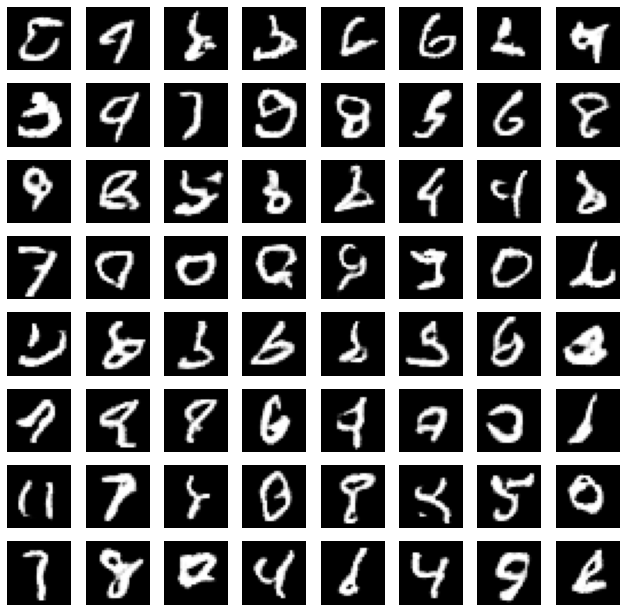

In [31]:
plots.plot_images(gen_samples[0:64].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(11,11))

In [16]:
def create_fc_gan(output_dim=28*28, latent_width=64, verbose=False):

    # generator
    gen = keras.models.Sequential(name='Generator')
    
    in_layer = Input(shape=(latent_width,), name='gen-input')
    gen.add(in_layer)
    
    gen.add(Dense(256, name='gen-fc1'))
    gen.add(LeakyReLU(0.2))
    gen.add(Dropout(0.3))
    
    gen.add(Dense(512, name='gen-fc2'))
    gen.add(LeakyReLU(0.2))
    gen.add(Dropout(0.3))
    
    gen.add(Dense(output_dim, activation='sigmoid', name='gen-output'))
    
    gen.add(Reshape((28, 28, 1)))


    # discriminator
    discr = keras.models.Sequential(name='Discriminator')
    discr.add(Input(shape=[28, 28, 1], name='discr-input'))
    discr.add(Flatten())
    
    discr.add(Dense(128, activation='relu', name='discr-fc1'))
    discr.add(Dropout(0.3))
    
    discr.add(Dense(32, activation='relu', name='discr-fc2'))
    discr.add(Dropout(0.3))

    discr.add(Dense(1, activation='sigmoid', name='discr-output'))
  

    # connect the two
    discr_in = gen(in_layer)
    output = discr(discr_in)

    gan = keras.Model(inputs=[in_layer], outputs=[output], name='GAN')
    
    discr.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0004, beta_1=0.5))
    discr.trainable = False
    
    # compile
    gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0004, beta_1=0.5))
    
    if verbose:
        gan.summary()
    
    return gan, gen, discr

In [17]:
latent_width = 100

gan, generator, discriminator = create_fc_gan(latent_width=latent_width, verbose=False)

generator.summary()
discriminator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen-fc1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
gen-fc2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
gen-output (Dense)           (None, 784)               40

...........

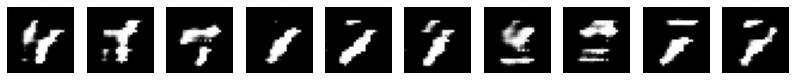


Epoch 0 - discriminator loss: 0.7263, gan loss: 0.7058
...........

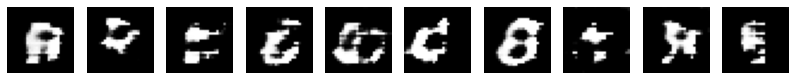


Epoch 1 - discriminator loss: 0.6596, gan loss: 0.7473
...........

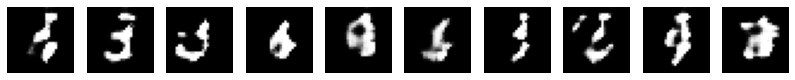


Epoch 2 - discriminator loss: 0.6761, gan loss: 0.7110
...........

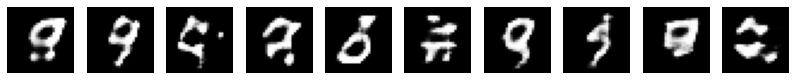


Epoch 3 - discriminator loss: 0.6850, gan loss: 0.6814
...........

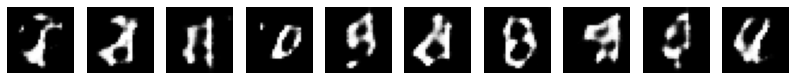


Epoch 4 - discriminator loss: 0.6881, gan loss: 0.7076
...........

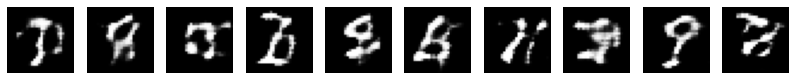


Epoch 5 - discriminator loss: 0.6812, gan loss: 0.7055
...........

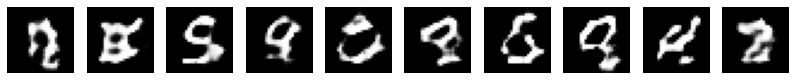


Epoch 6 - discriminator loss: 0.6894, gan loss: 0.7170
...........

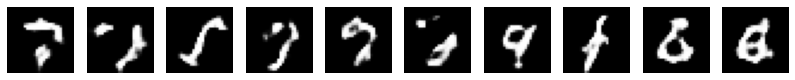


Epoch 7 - discriminator loss: 0.6876, gan loss: 0.7031
...........

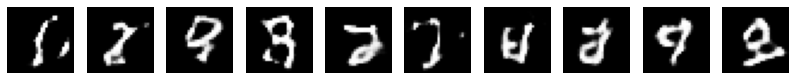


Epoch 8 - discriminator loss: 0.6874, gan loss: 0.7084
...........

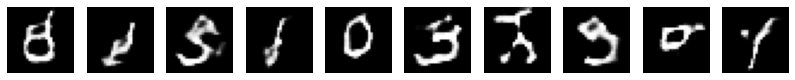


Epoch 9 - discriminator loss: 0.6891, gan loss: 0.7255


In [35]:
generator_fp = './gen_dnn.h5'

# train = False
train = True

if train:
    num_epochs = 10
    batch_size = 256

    for i in range(num_epochs):
        discr_loss_avg, gan_loss_avg = gan_train_loop(gan, generator, discriminator, train_x, 
                                                      batch_size=batch_size, latent_width=latent_width, verbose=True)

        print('Epoch {} - discriminator loss: {:.4f}, gan loss: {:.4f}'.format(i, discr_loss_avg, gan_loss_avg))
        
    generator.save(generator_fp)
else:
    gen_dnn = keras.models.load_model(generator_fp, compile=False)

In [40]:
noise_samples = tf.random.normal((100, latent_width), mean=0.0, stddev=1.0)
if train:
    gen_samples = generator.predict(noise_samples)
else:
    gen_samples = gen_dnn.predict(noise_samples)

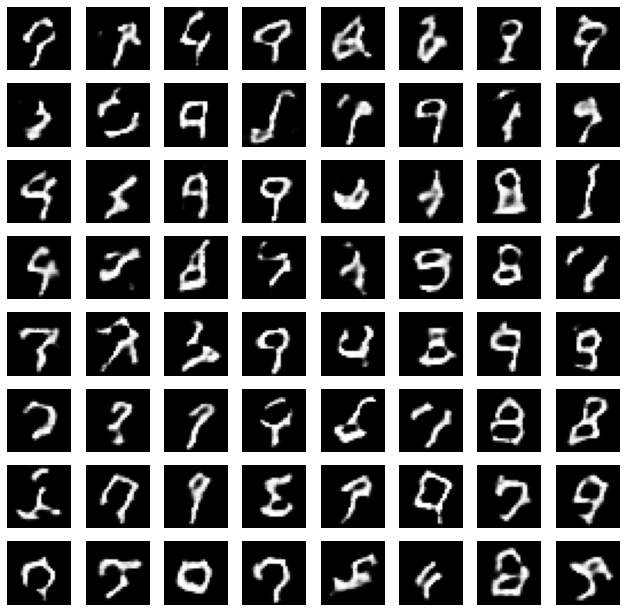

In [41]:
plots.plot_images(gen_samples[0:64].reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(11,11))